In [1]:
!pip install google-play-scraper pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 746.8 kB/s eta 0:00:00


In [2]:
!pip install vaderSentiment pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 947.4 kB/s eta 0:00:00


In [3]:
import pandas as pd
from google_play_scraper import Sort, reviews
app_id = 'com.zhiliaoapp.musically'
all_reviews = []
count = 9000
for _ in range(count // 200 + 1):
    reviews_batch, _ = reviews(
        app_id,
        lang='en',
        count=200,
        sort=Sort.NEWEST
    )
    all_reviews.extend(reviews_batch)
    if len(all_reviews) >= count:
        break
all_reviews = all_reviews[:count]
reviews_df = pd.DataFrame(all_reviews)
reviews_df = reviews_df[['userName', 'content', 'score', 'at']]
reviews_df.columns = ['username', 'review', 'score', 'time']
reviews_df.to_csv('tiktok_reviews.csv', index=False)
print("Data collection complete. Saved to tiktok_reviews.csv")

Data collection complete. Saved to tiktok_reviews.csv


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
reviews_df = pd.read_csv('tiktok_reviews.csv')
analyzer = SentimentIntensityAnalyzer()
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'
reviews_df['compound_score'] = reviews_df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
reviews_df['sentiment'] = reviews_df['compound_score'].apply(classify_sentiment)
reviews_df.to_csv('tiktok_reviews_labeled.csv', index=False)
print("Sentiment analysis complete. Saved to tiktok_reviews_labeled.csv")

Sentiment analysis complete. Saved to tiktok_reviews_labeled.csv


In [5]:
reviews_df['sentiment'].value_counts()

,count
sentiment,
positive,5040
neutral,2835
negative,1125


In [6]:
df = pd.read_csv('tiktok_reviews_labeled.csv')
df['sentiment'].value_counts()

,count
sentiment,
positive,5040
neutral,2835
negative,1125


In [7]:
df.head(10)

,username,review,score,time,compound_score,sentiment
0,Mark Lee,Good,5,2024-08-22 17:43:29,0.4404,positive
1,Salman Ahmed,Salman..jr.10,5,2024-08-22 17:43:18,0.0000,neutral
2,Jamie PlayStation,"Great app ,the only problem i have with this a...",4,2024-08-22 17:42:45,-0.1779,negative
3,Muhammad Khan,Very nice game 🎮,5,2024-08-22 17:42:34,0.4754,positive
4,Sarah Durodola,Very interesting,5,2024-08-22 17:42:10,0.4576,positive
5,Syed Haider Ali shah,My tiktok videos are not getting good views bu...,2,2024-08-22 17:41:01,-0.1878,negative
6,Lizeth Huerta,Cada que lo uso me agarra bastante almacenamie...,3,2024-08-22 17:40:34,0.0000,neutral
7,Shah Zain Shahid Ali,Shahzain Ali,5,2024-08-22 17:40:28,0.0000,neutral
8,ahmed suhan,এনডনন,1,2024-08-22 17:39:08,0.0000,neutral
9,Damien DeBois,Give me the new version now!,1,2024-08-22 17:38:49,0.0000,neutral


In [8]:
import string,re,nltk,spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # face related emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'https:\w+', '', text)
  text = text.lower().strip()
  doc = nlp(text)
  tokens = [token.text for token in doc if not token.is_stop and not token.text.isspace() and not token.is_punct]
  s=' '.join(tokens)
  doc=nlp(s)
  final_tokens=[]
  for i in doc:
    final_tokens.append(i.lemma_)
  return ' '.join(final_tokens)

In [9]:
df['cleaned_reviews']=df['review'].apply(preprocess_text)
df.head(10)

,username,review,score,time,compound_score,sentiment,cleaned_reviews
0,Mark Lee,Good,5,2024-08-22 17:43:29,0.4404,positive,good
1,Salman Ahmed,Salman..jr.10,5,2024-08-22 17:43:18,0.0000,neutral,salman jr.10
2,Jamie PlayStation,"Great app ,the only problem i have with this a...",4,2024-08-22 17:42:45,-0.1779,negative,great app problem app storage space take
3,Muhammad Khan,Very nice game 🎮,5,2024-08-22 17:42:34,0.4754,positive,nice game
4,Sarah Durodola,Very interesting,5,2024-08-22 17:42:10,0.4576,positive,interesting
5,Syed Haider Ali shah,My tiktok videos are not getting good views bu...,2,2024-08-22 17:41:01,-0.1878,negative,tiktok video get good view work hard observe e...
6,Lizeth Huerta,Cada que lo uso me agarra bastante almacenamie...,3,2024-08-22 17:40:34,0.0000,neutral,cada que lo uso agarra bastante almacenamiento...
7,Shah Zain Shahid Ali,Shahzain Ali,5,2024-08-22 17:40:28,0.0000,neutral,shahzain ali
8,ahmed suhan,এনডনন,1,2024-08-22 17:39:08,0.0000,neutral,এনডনন
9,Damien DeBois,Give me the new version now!,1,2024-08-22 17:38:49,0.0000,neutral,new version


In [10]:
df['target']=df['sentiment'].map({'positive':1,"negative":-1,'neutral':0})
df.head(10)

,username,review,score,time,compound_score,sentiment,cleaned_reviews,target
0,Mark Lee,Good,5,2024-08-22 17:43:29,0.4404,positive,good,1
1,Salman Ahmed,Salman..jr.10,5,2024-08-22 17:43:18,0.0000,neutral,salman jr.10,0
2,Jamie PlayStation,"Great app ,the only problem i have with this a...",4,2024-08-22 17:42:45,-0.1779,negative,great app problem app storage space take,-1
3,Muhammad Khan,Very nice game 🎮,5,2024-08-22 17:42:34,0.4754,positive,nice game,1
4,Sarah Durodola,Very interesting,5,2024-08-22 17:42:10,0.4576,positive,interesting,1
5,Syed Haider Ali shah,My tiktok videos are not getting good views bu...,2,2024-08-22 17:41:01,-0.1878,negative,tiktok video get good view work hard observe e...,-1
6,Lizeth Huerta,Cada que lo uso me agarra bastante almacenamie...,3,2024-08-22 17:40:34,0.0000,neutral,cada que lo uso agarra bastante almacenamiento...,0
7,Shah Zain Shahid Ali,Shahzain Ali,5,2024-08-22 17:40:28,0.0000,neutral,shahzain ali,0
8,ahmed suhan,এনডনন,1,2024-08-22 17:39:08,0.0000,neutral,এনডনন,0
9,Damien DeBois,Give me the new version now!,1,2024-08-22 17:38:49,0.0000,neutral,new version,0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [12]:
X=df['cleaned_reviews']
y=df['target']
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [13]:
pipe = Pipeline([
    ('vectorizer',TfidfVectorizer()),
    ('model',SVC())
])

In [14]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('model', SVC())])

In [15]:
y_pred=pipe.predict(X_test)

In [16]:
print(accuracy_score(y_pred,y_test))

0.9711111111111111


In [17]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          -1       0.92      1.00      0.96       219
           0       0.94      1.00      0.97       531
           1       1.00      0.95      0.97      1050

    accuracy                           0.97      1800
   macro avg       0.95      0.98      0.97      1800
weighted avg       0.97      0.97      0.97      1800



Text(50.722222222222214, 0.5, 'Actual')

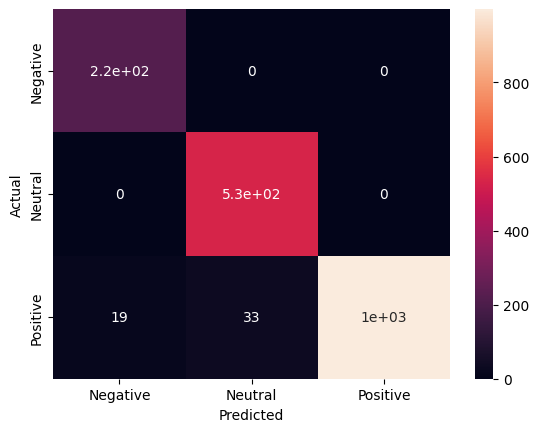

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True,xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [19]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

          -1       0.92      1.00      0.96       219
           0       0.94      1.00      0.97       531
           1       1.00      0.95      0.97      1050

    accuracy                           0.97      1800
   macro avg       0.95      0.98      0.97      1800
weighted avg       0.97      0.97      0.97      1800



In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_pred_bin = label_binarize(y_pred, classes=[-1, 0, 1])
auroc = roc_auc_score(y_test_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUROC: {auroc:.2f}")

AUROC: 0.97


In [20]:
pipe.predict([''])